In [2]:
import numpy as np
import matplotlib.pyplot as plt

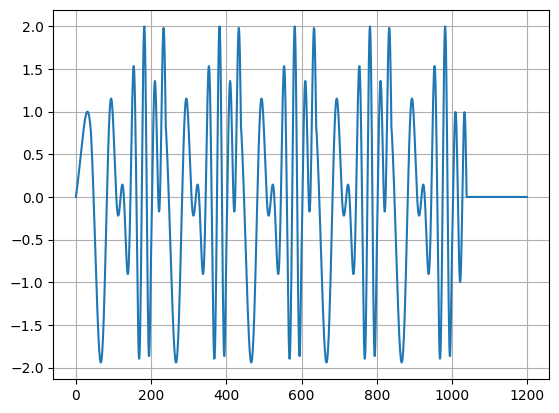

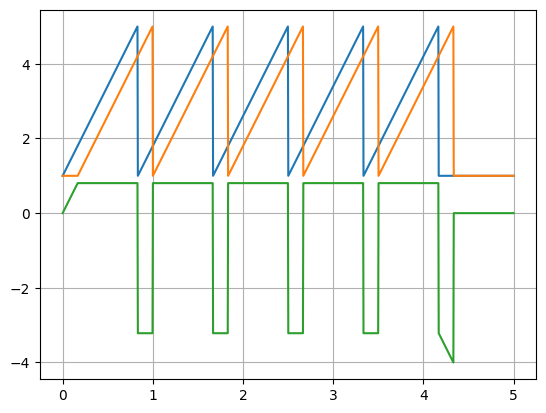

In [16]:
domain = np.linspace(0,1,200)
frequency_increaser = np.linspace(1,5,200)
amplitude = np.sin(2*np.pi*domain*frequency_increaser)

n_chirps = 5

full_signal = np.array([])
full_chirps = np.array([])

for _ in range(n_chirps):
    full_signal = np.concatenate((full_signal, amplitude))
    full_chirps = np.concatenate((full_chirps, frequency_increaser))
    
full_signal = np.concatenate((full_signal, np.zeros(200)))
full_chirps = np.concatenate((full_chirps, np.ones(200)))

full_signal_domain = np.linspace(0, n_chirps, len(full_signal))

recieved_signal = np.concatenate((np.zeros(40), full_signal))[0:len(full_signal)]
recieved_chirps = np.concatenate((np.ones(40), full_chirps))[0:len(full_chirps)]

plt.figure()
# plt.plot(full_signal)
# plt.plot(recieved_signal)
plt.plot(full_signal - recieved_signal)
plt.grid('on')
plt.show()

plt.figure()
plt.plot(full_signal_domain, full_chirps)
plt.plot(full_signal_domain, recieved_chirps)
plt.plot(full_signal_domain, full_chirps - recieved_chirps)
plt.grid('on')
plt.show()

In [11]:
class MySignal:
    def __init__(self, f0, f1, emission_duration, n_emissions, inter_frame_time, pulses, pulse_duration, idle_time, sampling_rate):
        self.f0 = f0 # initial frequency
        self.f1 = f1 # final frequency
        self.cicle_duration = emission_duration # duration of the signal
        self.n_cicles = n_emissions # number of cicles
        self.inter_frame_time = inter_frame_time # idle time between cicles
        self.pulses = pulses # number of pulses
        self.pulse_duration = pulse_duration # duration of each pulse
        self.idle_time = idle_time # idle time between pulses
        self.time = np.linspace(0, emission_duration, int(emission_duration*sampling_rate))
        self.slope = (f1 - f0) / pulse_duration
        
    def get_signal(self):
        signal = np.zeros(len(self.time))
        for i in range(self.pulses):
            signal += np.sin(2*np.pi*(self.f0 + self.slope*self.time)*self.time)
        return signal
        

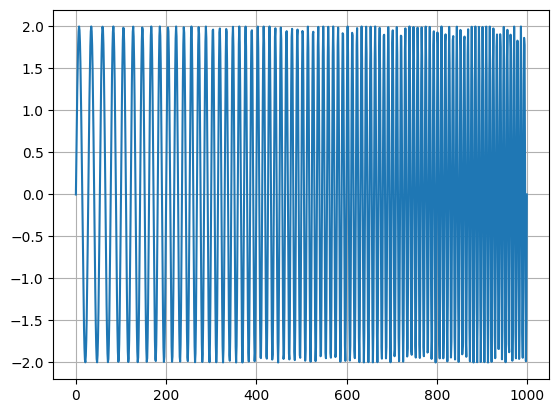

In [14]:
sinal = MySignal(7, 11, 5, 1, 2, 2, 200).get_signal()

plt.figure()
plt.plot(sinal)
plt.grid('on')
plt.show()

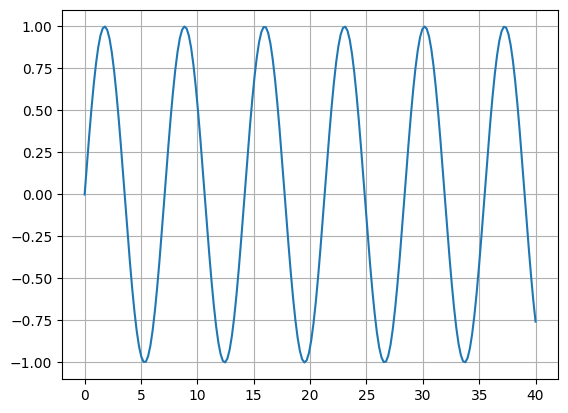

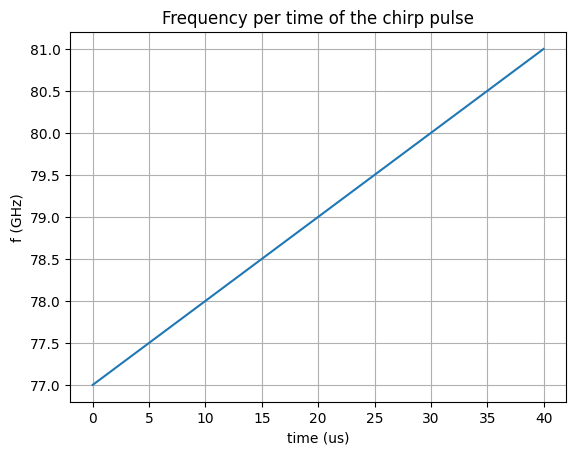

In [6]:
chirp_period = 40 #us
wave_period = 8 #us
fmin = 77 #GHz
Slope = 0.1 # 100 MHz/us
fmax = fmin + Slope*chirp_period
amplitude = 1

step = 200

domain = np.linspace(0,chirp_period,step)

w1 = 2*np.pi/wave_period
w2 = 2*np.pi/wave_period

phase1 = 0
phase2 = 1

tx = amplitude*np.sin((w1+Slope)*domain + phase1)
rx = amplitude*np.sin((w2+Slope)*domain + phase2)

# intermediate_frequency = tx - rx

plt.figure()
plt.plot(domain, tx)
plt.grid('on')
# plt.plot(domain, rx)
# plt.plot(domain, intermediate_frequency)
plt.show()

plt.figure()
plt.title('Frequency per time of the chirp pulse')
plt.ylabel('f (GHz)')
plt.xlabel('time (us)')
plt.grid('on')
plt.plot(domain,(Slope)*domain+fmin)
plt.show()


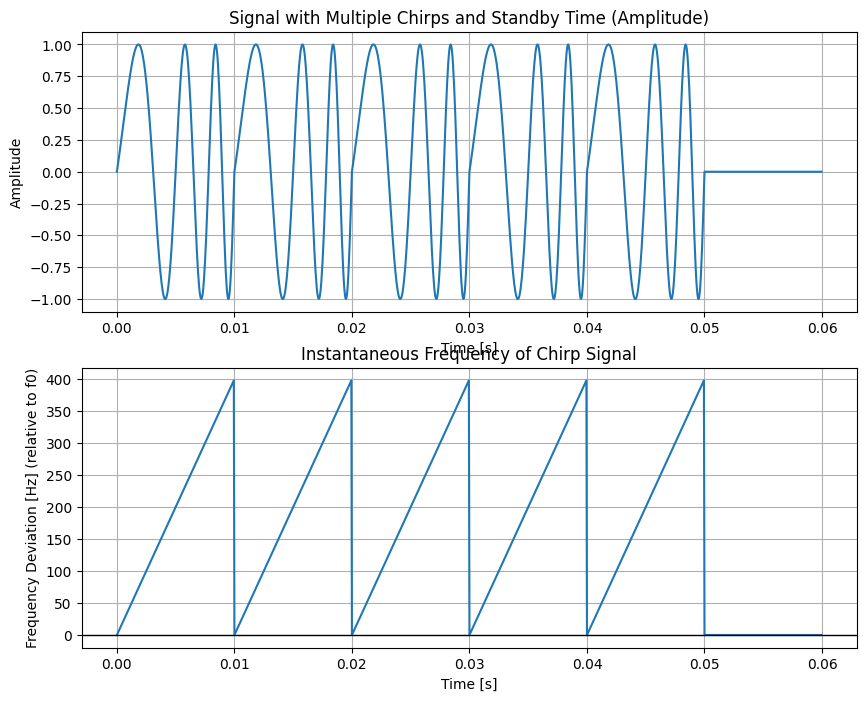

In [7]:
class ChirpPulse:
    def __init__(self, f0, f1, duration, sampling_rate):
        """
        Initialize the ChirpPulse object.
        
        Args:
        f0 (float): Start frequency of the chirp in Hz.
        f1 (float): End frequency of the chirp in Hz.
        duration (float): Duration of the chirp in seconds.
        sampling_rate (float): Sampling rate in Hz.
        """
        self.f0 = f0  # Start frequency
        self.f1 = f1  # End frequency
        self.duration = duration  # Duration of the pulse in seconds
        self.sampling_rate = sampling_rate  # Sampling rate in Hz
        self.time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  # Time array

    def linear_chirp(self):
        """
        Generate a linear chirp pulse.
        
        Returns:
        numpy.ndarray: A numpy array representing the chirp pulse.
        """
        # Calculate instantaneous frequency at each time step
        k = (self.f1 - self.f0) / self.duration  # Rate of change of frequency
        instantaneous_phase = 2 * np.pi * (self.f0 * self.time + (k / 2) * self.time ** 2)  # Phase
        signal = np.sin(instantaneous_phase)  # Chirp signal based on phase
        return signal

    def instantaneous_frequency(self):
        """
        Calculate the instantaneous frequency of the chirp at each time step.
        
        Returns:
        numpy.ndarray: Instantaneous frequency array.
        """
        k = (self.f1 - self.f0) / self.duration  # Rate of change of frequency
        return self.f0 + k * self.time  # Linear frequency sweep


class ChirpSignal:
    def __init__(self, chirp, num_chirps, standby_time, end_standby_time, sampling_rate):
        """
        Initialize the ChirpSignal object.
        
        Args:
        chirp (ChirpPulse): A ChirpPulse object to generate individual chirps.
        num_chirps (int): Number of chirp pulses in the signal.
        standby_time (float): Silent time between chirps in seconds.
        end_standby_time (float): Silent time at the end of the signal in seconds.
        sampling_rate (float): Sampling rate in Hz.
        """
        self.chirp = chirp
        self.num_chirps = num_chirps
        self.standby_time = standby_time
        self.end_standby_time = end_standby_time
        self.sampling_rate = sampling_rate

    def generate_signal(self):
        """
        Generate a signal consisting of multiple chirps with standby time.
        
        Returns:
        numpy.ndarray: A numpy array representing the full signal.
        """
        # Generate one chirp pulse
        chirp_signal = self.chirp.linear_chirp()
        
        # Create a silent period (standby) of zeros between chirps
        standby_samples = int(self.standby_time * self.sampling_rate)
        standby_signal = np.zeros(standby_samples)
        
        # Create the full signal with chirps and standby between them
        full_signal = np.array([])
        for _ in range(self.num_chirps):
            full_signal = np.concatenate([full_signal, chirp_signal, standby_signal])
        
        # Add the final silent period (end_standby_time) at the end
        end_standby_samples = int(self.end_standby_time * self.sampling_rate)
        end_standby_signal = np.zeros(end_standby_samples)
        full_signal = np.concatenate([full_signal, end_standby_signal])
        
        return full_signal

    def generate_frequency_profile(self):
        """
        Generate the frequency profile of the signal consisting of multiple chirps.
        
        Returns:
        numpy.ndarray: Instantaneous frequency profile of the full signal.
        """
        # Get the instantaneous frequency of a single chirp
        chirp_frequency = self.chirp.instantaneous_frequency()
        
        # Create a silent period (standby) of zeros between chirps
        standby_samples = int(self.standby_time * self.sampling_rate)
        standby_frequency = np.full(standby_samples, self.chirp.f0)  # Frequency remains at f0 during silence
        
        # Create the full frequency profile with chirps and standby between them
        full_frequency = np.array([])
        for _ in range(self.num_chirps):
            full_frequency = np.concatenate([full_frequency, chirp_frequency, standby_frequency])
        
        # Add the final silent period (end_standby_time) at the end
        end_standby_samples = int(self.end_standby_time * self.sampling_rate)
        end_standby_frequency = np.full(end_standby_samples, self.chirp.f0)
        full_frequency = np.concatenate([full_frequency, end_standby_frequency])
        
        return full_frequency

    def plot(self):
        """
        Plot both the amplitude of the signal and the instantaneous frequency over time.
        """
        # Time vector for the whole signal
        total_time = (self.num_chirps * (self.chirp.duration + self.standby_time) + self.end_standby_time)
        time_vector = np.linspace(0, total_time, int(self.sampling_rate * total_time), endpoint=False)
        
        # Get the signal and frequency profile
        signal = self.generate_signal()
        frequency_profile = self.generate_frequency_profile()
        
        # Create the plot with two subplots (Amplitude plot and Frequency plot)
        plt.figure(figsize=(10, 8))

        # Plot 1: Amplitude of the signal (original plot)
        plt.subplot(2, 1, 1)
        plt.plot(time_vector, signal)
        plt.title('Signal with Multiple Chirps and Standby Time (Amplitude)')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.grid(True)

        # Plot 2: Frequency deviation from f0 (new plot)
        plt.subplot(2, 1, 2)
        plt.plot(time_vector, frequency_profile - self.chirp.f0)  # Center around f0
        plt.title('Instantaneous Frequency of Chirp Signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency Deviation [Hz] (relative to f0)')
        plt.grid(True)
        plt.axhline(0, color='black', linewidth=1)  # Centered around f0
        

# Example of creating and using the ChirpSignal class

# Parameters for the chirp
f0 = 100  # Start frequency of the chirp (Hz)
f1 = 500  # End frequency of the chirp (Hz)
duration = 0.01  # Duration of the chirp pulse (10 ms)
sampling_rate = 20000  # Sampling rate (samples per second)

# Create a ChirpPulse object
chirp = ChirpPulse(f0, f1, duration, sampling_rate)

# Parameters for the signal
num_chirps = 5  # Number of chirps in the signal
standby_time = 0  # Standby time between chirps (20 ms)
end_standby_time = 0.01  # Silent time at the end of the signal (500 ms)

# Create a ChirpSignal object
chirp_signal = ChirpSignal(chirp, num_chirps, standby_time, end_standby_time, sampling_rate)

# Generate and plot the signal
chirp_signal.plot()
